In this assignment, you will apply the linear models we learned in class and practiced in Q2.2_linear to your own project.

-    Write your code in a jupyter notebook named P2.2_linear.ipynb
-    Submit P2.2_linear.ipynb to Gradescope: P2.2_linear 

-   Links to an external site.

Note that in your implementation, we recommend you to:

-    if you have a regression task, explore linear regression, lasso, ridge, and polynomial regression
-    if you have a classification task, explore logistic regression with l1 and l2 penalty, and different magnitude of C values
-    explore other parameter settings that could potentially affect your model performance, find a model that works best on your data
-    comment on important steps
-    interpret model performance
-    discuss pros and cons of each model



#### Important modules for import ####

In [18]:
import os
import numpy as np
import pandas as pd
import re, string

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem import PorterStemmer

import gensim

from tqdm import tqdm
from bs4 import BeautifulSoup

# for counting
from collections import Counter

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## THIS is where the code begins ##

In [19]:
## IMPORT OUR CLEANED DATA ##
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\newest_all_df.pkl")

In [20]:
all_df.isna().sum()

user                  979
user_flair         247339
post_date               0
post_flair         297083
score                  74
n_comments         287462
link                51459
is_comment              0
subreddit               0
full_text               0
cleaner_text            0
full_tokens             0
norm_tokens             0
tokens_sents            0
norm_sents              0
POS_sents               0
is_adoptee              0
num_tokens              0
num_norm_tokens         0
sentiment               0
dtype: int64

In [21]:
all_df = all_df[(all_df.is_adoptee < 2) & (all_df.num_tokens > 25)] 

Find our stopwords

In [22]:
stop_words = stopwords.words('english')

#### GETTING INTO MACHINE LEARNING, VECTORIZATION, REGRESSION, ETC ####

It is important to tune the max_df, min_df parameters and possibly add more stop words. For this example, I will use a count vectorizer (bag of words) for this classification task

In [23]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stop_words, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(all_df.cleaner_text)
y = all_df.is_adoptee

#### Train and test splitting ####

In [24]:
train_idx, test_idx = train_test_split(np.arange(all_df.shape[0]), test_size=0.3, 
                                       shuffle=True, random_state=42)

X_train = X[train_idx]
y_train = y.iloc[train_idx]

X_test = X[test_idx]
y_test = y.iloc[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (27908, 16963), y_train : (27908,)
Testing data: X_test : (11961, 16963), y_test : (11961,)


## Logistic Regression ##


We can see that the logistic regression model classifies the texts to the correct label in .701 of all cases. This accuracy is still not good considering that 2/3 of the labels are nonadoptee vs adoptee.

We can see that although the accuracy is okay, this does not take into consideration the sample imbalance. We see that most of the reason accuracy is so high is because of the high number of true negatives. We see that the recall rate for adoptee posts is quite low at .394. This means that the model only finds 40% of all the posts truly written by adoptees. Furthermore the adoptee precision is .578 meaning that only a little bit more than half of the predicted adoptee posts were true adoptee posts. We can see the f1 score for adoptee posts is also quite low.

Accuracy: 0.737
adoptee Precision: 0.771
non_adoptee Precision: 0.681
adoptee Recall: 0.799
non_adoptee Recall: 0.643
adoptee f1: 0.785
non_adoptee f1: 0.661


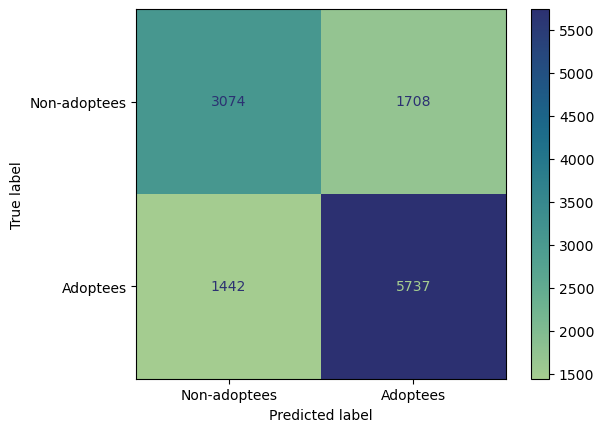

In [25]:
# create the classifier
lr_clf = LogisticRegression() # adds L2 penalty by default
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Let us now try to change the c value in the logistic regression model.

We see that decreasing the inverse regularization strength causes the model to increase the strength of the regularization term, thereby leading to less overfitting. However, we see that reducing C by this much has led to even worse model performance than leaving C = 1 (for adoptee posts recall and f1 are much worse)

Accuracy: 0.708
adoptee Precision: 0.693
non_adoptee Precision: 0.765
adoptee Recall: 0.921
non_adoptee Recall: 0.388
adoptee f1: 0.791
non_adoptee f1: 0.515


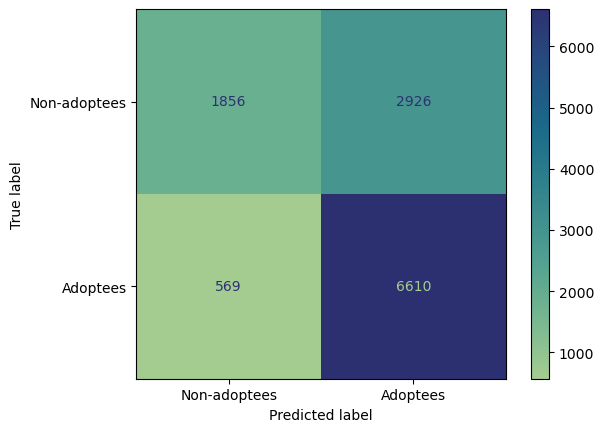

In [26]:
# create the classifier
lr_clf = LogisticRegression(C=.001)
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Let's try a model with both l1 and l2 penalties.


With both penalities the model performs still worse than the base model with an l2 regularization penalty. Though the accuracy is higher, recall and f1 is worse. This model is better than the model with  l2 and c = .001

Accuracy: 0.739
adoptee Precision: 0.753
non_adoptee Precision: 0.712
adoptee Recall: 0.843
non_adoptee Recall: 0.584
adoptee f1: 0.795
non_adoptee f1: 0.642


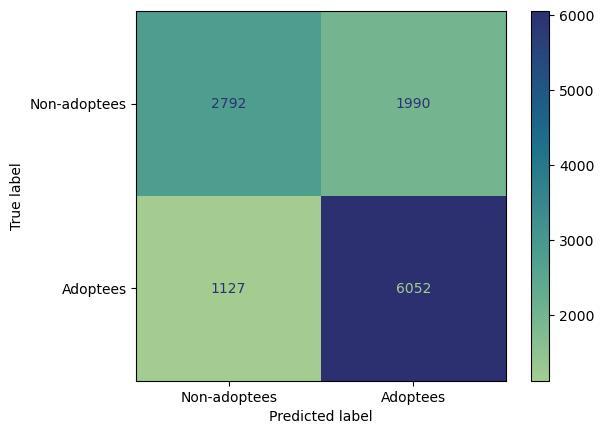

In [27]:
# create the classifier
lr_clf = LogisticRegression(penalty="elasticnet", C=.1, solver="saga", l1_ratio=0.5 )
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

We see that there is not much improvement through tinkering with the hyperparameters for logistic regression. Let us now try a different vectorizer to see whether we get any improvement.

In [28]:
summed_truth = all_df['norm_sents'].sum()

In [29]:
# code from content analysis week4 hw
truth_w2v = gensim.models.word2vec.Word2Vec(summed_truth, sg=0)

In [30]:
# save model
truth_w2v.wv.save("adopt_word2vec_new")

In [31]:
# code aided by ChatGPT and content analysis hw4
X = []
for sentence in all_df['norm_tokens']:
    # create a list of word vectors for a given sentence
    vectors = []
    for word in sentence:
        # Check if the word is in the vocabulary of the Word2Vec model
        if word in truth_w2v.wv:
            vectors.append(truth_w2v.wv[word])
    if vectors:
        # Calculate the mean vector if at least one word is found in the vocabulary
        X.append(np.mean(vectors, axis=0))
    else:
        # for sentences with no words in vocabulary add an empty vector
        X.append(np.zeros(truth_w2v.vector_size))  # Use the vector size of the Word2Vec model

y = all_df.is_adoptee

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We see that using a word2vec vectorizer, the model does not perform well.  Accuracy is 2/3 but the sample split is also close to that so this model is not good. Similar to the decision tree from the last project part, it labels almost all posts as non adoptee. Adoptee F1 and recall are very low.

Accuracy: 0.665
adoptee Precision: 0.665
non_adoptee Precision: 0.664
adoptee Recall: 0.893
non_adoptee Recall: 0.321
adoptee f1: 0.762
non_adoptee f1: 0.433


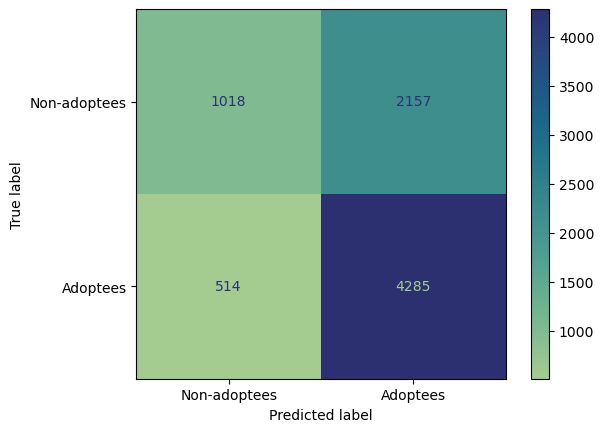

In [33]:
lr_clf = LogisticRegression(C=.001) # adds L2 penalty by default
# fit the data
lr_clf.fit(X_train, y_train)

# find the predicted y from test data
y_test_pred =  lr_clf.predict(X_test)

# plot the confusion matrix
con_mat = confusion_matrix(y_test, y_test_pred)
# help displaying a confusion matrix with labels
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
labels = ['Non-adoptees', 'Adoptees']
cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
cmd.plot(cmap="crest")

# finding the different measurements
tn, fp, fn, tp = con_mat.ravel()

print(f"Accuracy: {round((tp + tn) / (tp + tn + fp + fn),3)}")
print(f"adoptee Precision: {round(tp / (tp + fp),3)}")
print(f"non_adoptee Precision: {round(tn / (tn + fn),3)}")
print(f"adoptee Recall: {round(tp / (tp + fn),3)}")
print(f"non_adoptee Recall: {round(tn / (tn + fp),3)}")
print(f"adoptee f1: {round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp) + tp / (tp + fn))), 3)}")
print(f"non_adoptee f1: {round(2 * ((tn / (tn + fn)) * (tn / (tn + fp))) / ((tn / (tn + fn)) + (tn / (tn + fp))), 3)}")

Overall, we see that the best model was the base logistic regression model (with l2 penalty already applied). We see that we can increase accuracy to around .74 but the con for using the model that takes into consideration l1 and l2 penalties is that adoptee recall and f1 score are reduced. Overall we note that accuracy here tells us very little in regards to how well the model performs given the uneven split of X and y training and testing data. We prioritize looking at other measures like recall, precision, and F1 to formulate which model fits the best. We see that logistic regression performs ever so slightly better than decision trees but not significantly. Our data, it seems, remains hard to classify using traditional machine learning classification methods.